In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [2]:
data = pd.read_csv('../data/retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [4]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [5]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    # your_code
    
    items = np.array(items_weights['item_id'])
    weights = np.array(items_weights['weight'])
    # Используем параметр p
    recs = np.random.choice(items,
                            size=n,
                            replace=False,
                            p=weights)

    return recs.tolist()

In [6]:
%%time

# your_code
# Считаем продажи каждого товара, берем логарифм
# Полученные значения делаем положительными и приводим к единичной сумме
item_weights = data_train.groupby('item_id')['sales_value'].sum().reset_index()
item_weights['sales_value'] = np.log2(item_weights['sales_value'] + 0.001)
item_weights['sales_value'] = item_weights['sales_value'] - item_weights['sales_value'].min()
item_weights['sales_value'] = item_weights['sales_value'] / item_weights['sales_value'].sum()
item_weights = item_weights.rename(columns={'sales_value': 'weight'})
item_weights

CPU times: user 37 ms, sys: 6.54 ms, total: 43.5 ms
Wall time: 42.9 ms


,item_id,weight
0,25671,0.000012
1,26081,0.000008
2,26093,0.000009
3,26190,0.000009
4,26355,0.000009
...,...,...
86860,17381856,0.000000
86861,17382205,0.000011
86862,17383227,0.000010
86863,17827644,0.000010


In [7]:
%%time

result['w_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(item_weights, n=5))
result.head(2)

CPU times: user 1.61 s, sys: 312 ms, total: 1.92 s
Wall time: 1.92 s


,user_id,actual,w_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[741207, 13190101, 1015446, 9526885, 862551]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1064408, 934409, 6979221, 1057114, 5693713]"


### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

In [8]:
result = pd.read_csv('data/predictions_basic.csv')
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[5586238, 1015228, 866118, 2416733, 2603573]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]","[981760, 1127831, 1098066, 826249, 878996]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[161354, 63027, 1027802, 12263694, 307395]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]","[981760, 1004906, 859075, 1096036, 961554]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [31]:
# from my_metrics import precision_at_k

In [120]:
def eval_0(item):
    garbage = ['[', ']',',', '.']
    for g in garbage:
        item = str(item).replace(g, '')
    item = list(map(int, item.split()))
    return item

def eval_actual(item):
    garbage = ['[', ']', '\n']
    for g in garbage:
        item = item.replace(g, '')
    item = list(map(int, item.split()))
    return item

def precision_at_k(x, k=5):
    
    recommended_list = x[0]
    bought_list = x[1]
    
    bought_list = eval_actual(bought_list)
    bought_list = np.array(bought_list)
    
    recommended_list = eval_0(recommended_list)
    recommended_list = np.array(recommended_list)
    
    recommended_list = recommended_list[:k]
    
    flags = np.isin(recommended_list, bought_list)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [32]:
# # your_code
# rec_metrics = {}
# for col in result.columns[1:]:
#     rec_metrics[col] = round(result.apply(lambda row: precision_at_k(row[col], row['actual']), axis=1).mean(), 4)

In [121]:
k = 5
model_names = result.columns.tolist()[2:]
for model in model_names:
    result[f'{model}_precision@{k}'] = result[[model, 'actual']].apply(precision_at_k, axis=1)

model_mask = ['@' in col for col in result.columns]
cols = result.columns.tolist()
model_cols = [cols[i] for i in range(len(cols)) if model_mask[i]]

result[model_cols].mean()

random_recommendation_precision@5                 0.000588
popular_recommendation_precision@5                0.155240
itemitem_precision@5                              0.033595
cosine_precision@5                                0.035260
tfidf_precision@5                                 0.036141
own_purchases_precision@5                         0.179987
random_recommendation_precision@5_precision@5     0.000000
popular_recommendation_precision@5_precision@5    0.000000
itemitem_precision@5_precision@5                  0.000000
cosine_precision@5_precision@5                    0.000000
tfidf_precision@5_precision@5                     0.000000
own_purchases_precision@5_precision@5             0.000000
random_recommendation_5000_precision@5            0.006170
popular_recommendation_5000_precision@5           0.155240
w_random_recommendation_5000_precision@5          0.010970
dtype: float64

### Задание 3*. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.

**Бейзлайны**

**1. Random recommendation**

In [122]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [123]:
%%time

items = data_train['item_id'].iloc[:5000].unique()

result['random_recommendation_5000'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

result.head(2)

CPU times: user 113 ms, sys: 3.18 ms, total: 116 ms
Wall time: 114 ms


,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,random_recommendation_precision@5,popular_recommendation_precision@5,...,w_random_recommendation_5000,random_recommendation_precision@5_precision@5,popular_recommendation_precision@5_precision@5,itemitem_precision@5_precision@5,cosine_precision@5_precision@5,tfidf_precision@5_precision@5,own_purchases_precision@5_precision@5,random_recommendation_5000_precision@5,popular_recommendation_5000_precision@5,w_random_recommendation_5000_precision@5
0,1,[ 821867 834484 856942 865456 889248 ...,"[5586238, 1015228, 866118, 2416733, 2603573]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]","[981760, 1127831, 1098066, 826249, 878996]","[999999, 1082185, 1029743, 995785, 1004906]",0.0,0.2,...,"[1118623, 901666, 12262978, 988693, 922561]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
1,3,[ 835476 851057 872021 878302 879948 ...,"[161354, 63027, 1027802, 12263694, 307395]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]","[981760, 1004906, 859075, 1096036, 961554]","[999999, 1082185, 1098066, 6534178, 1127831]",0.0,0.0,...,"[838186, 985605, 863885, 1118623, 7409874]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**2. Popularity-based recommendation**

In [124]:
def popularity_recommendation_5000(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular = popular.sort_values('sales_value', ascending=False).iloc[:5000]
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [125]:
%%time

# Можно так делать, так как рекомендация не зависит от юзера
popular_recs = popularity_recommendation_5000(data_train, n=5)

result['popular_recommendation_5000'] = result['user_id'].apply(lambda x: popular_recs)
result.head(2)

CPU times: user 71.7 ms, sys: 28.5 ms, total: 100 ms
Wall time: 107 ms


,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,random_recommendation_precision@5,popular_recommendation_precision@5,...,w_random_recommendation_5000,random_recommendation_precision@5_precision@5,popular_recommendation_precision@5_precision@5,itemitem_precision@5_precision@5,cosine_precision@5_precision@5,tfidf_precision@5_precision@5,own_purchases_precision@5_precision@5,random_recommendation_5000_precision@5,popular_recommendation_5000_precision@5,w_random_recommendation_5000_precision@5
0,1,[ 821867 834484 856942 865456 889248 ...,"[5586238, 1015228, 866118, 2416733, 2603573]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]","[981760, 1127831, 1098066, 826249, 878996]","[999999, 1082185, 1029743, 995785, 1004906]",0.0,0.2,...,"[1118623, 901666, 12262978, 988693, 922561]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
1,3,[ 835476 851057 872021 878302 879948 ...,"[161354, 63027, 1027802, 12263694, 307395]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]","[981760, 1004906, 859075, 1096036, 961554]","[999999, 1082185, 1098066, 6534178, 1127831]",0.0,0.0,...,"[838186, 985605, 863885, 1118623, 7409874]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**3. Weighted Random Recommendation**

In [126]:
%%time

# your_code
# Считаем продажи каждого товара, берем логарифм
# Полученные значения делаем положительными и приводим к единичной сумме
item_weights_5000 = data_train.groupby('item_id')['sales_value'].sum().reset_index()
item_weights_5000 = item_weights_5000.sort_values('sales_value', ascending=False).iloc[:5000]
item_weights_5000['sales_value'] = np.log2(item_weights_5000['sales_value'] + 0.001)
item_weights_5000['sales_value'] = item_weights_5000['sales_value'] - item_weights_5000['sales_value'].min()
item_weights_5000['sales_value'] = item_weights_5000['sales_value'] / item_weights_5000['sales_value'].sum()
item_weights_5000 = item_weights_5000.rename(columns={'sales_value': 'weight'})
item_weights_5000

CPU times: user 72.1 ms, sys: 10.4 ms, total: 82.4 ms
Wall time: 78.8 ms


,item_id,weight
55470,6534178,2.034427e-03
55430,6533889,1.376497e-03
28895,1029743,1.342572e-03
55465,6534166,1.296012e-03
34707,1082185,1.255600e-03
...,...,...
72352,12188446,1.651475e-07
37958,1112387,1.341899e-07
23584,981716,4.129621e-08
51978,5575861,1.032464e-08


In [127]:
%%time

result['w_random_recommendation_5000'] = result['user_id'].apply(lambda x: weighted_random_recommendation(item_weights_5000, n=5))
result.head(2)

CPU times: user 176 ms, sys: 18.1 ms, total: 194 ms
Wall time: 192 ms


,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,random_recommendation_precision@5,popular_recommendation_precision@5,...,w_random_recommendation_5000,random_recommendation_precision@5_precision@5,popular_recommendation_precision@5_precision@5,itemitem_precision@5_precision@5,cosine_precision@5_precision@5,tfidf_precision@5_precision@5,own_purchases_precision@5_precision@5,random_recommendation_5000_precision@5,popular_recommendation_5000_precision@5,w_random_recommendation_5000_precision@5
0,1,[ 821867 834484 856942 865456 889248 ...,"[5586238, 1015228, 866118, 2416733, 2603573]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]","[981760, 1127831, 1098066, 826249, 878996]","[999999, 1082185, 1029743, 995785, 1004906]",0.0,0.2,...,"[1125837, 890739, 962991, 995785, 838186]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
1,3,[ 835476 851057 872021 878302 879948 ...,"[161354, 63027, 1027802, 12263694, 307395]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]","[981760, 1004906, 859075, 1096036, 961554]","[999999, 1082185, 1098066, 6534178, 1127831]",0.0,0.0,...,"[1135071, 837865, 1021164, 931579, 957232]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
result.columns[2:]

Index(['random_recommendation', 'popular_recommendation', 'itemitem', 'cosine',
       'tfidf', 'own_purchases', 'random_recommendation_precision@5',
       'popular_recommendation_precision@5', 'itemitem_precision@5',
       'cosine_precision@5', 'tfidf_precision@5', 'own_purchases_precision@5',
       'random_recommendation_5000', 'popular_recommendation_5000',
       'w_random_recommendation_5000',
       'random_recommendation_precision@5_precision@5',
       'popular_recommendation_precision@5_precision@5',
       'itemitem_precision@5_precision@5', 'cosine_precision@5_precision@5',
       'tfidf_precision@5_precision@5',
       'own_purchases_precision@5_precision@5',
       'random_recommendation_5000_precision@5',
       'popular_recommendation_5000_precision@5',
       'w_random_recommendation_5000_precision@5',
       'random_recommendation_precision@5_precision@5_precision@5',
       'popular_recommendation_precision@5_precision@5_precision@5',
       'itemitem_precision@5_p

In [149]:
%%time

# your_code
rec_metrics_5000 = {}
for col in result.columns[2:]:
    rec_metrics_5000[col] = result[[col, 'actual']].apply(precision_at_k, axis=1).mean()




CPU times: user 1.67 s, sys: 7.47 ms, total: 1.68 s
Wall time: 1.68 s


In [150]:
pd.DataFrame(pd.Series(rec_metrics_5000)).T

,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,random_recommendation_precision@5,popular_recommendation_precision@5,itemitem_precision@5,cosine_precision@5,...,w_random_recommendation_5000_precision@5,random_recommendation_precision@5_precision@5_precision@5,popular_recommendation_precision@5_precision@5_precision@5,itemitem_precision@5_precision@5_precision@5,cosine_precision@5_precision@5_precision@5,tfidf_precision@5_precision@5_precision@5,own_purchases_precision@5_precision@5_precision@5,random_recommendation_5000_precision@5_precision@5,popular_recommendation_5000_precision@5_precision@5,w_random_recommendation_5000_precision@5_precision@5
0,0.000588,0.15524,0.033595,0.03526,0.036141,0.179987,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Популярные рекомендации не стали лучше, что вполне понятно. Случайные невзвешенные и взвешенные рекомендации улучшились значительно (что понятно для взвешенных рекомендаций).

**Улучшенные ItemItemRecommender**

In [ ]:
# your_code

In [157]:
def precision_at_k_1(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    #print(flags)
    
    precision = flags.sum() / len(recommended_list)
    
    return precision

In [158]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,202291,35911
1,397896,1214994
2,420647,168661
3,480014,371107
4,545926,20134


In [159]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [160]:
# Заведем фиктивный item_id (если юзер НЕ покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix (позволяет в сжатом виде хранить большие матрицы, где много нулей)
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
# перенумеруем пользователей и товары
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [162]:
%%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: user 549 ms, sys: 30 ms, total: 579 ms
Wall time: 580 ms


In [172]:
def get_recommendations(user, model, sparse_user_item, N=5):
    res = [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item[userid_to_id[user]],   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)[0]]
    return res

In [175]:
resulti = result[['user_id', 'actual']]

In [179]:
resulti['itemitem'] = resulti['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))

/var/folders/j2/7fhv7lr576j7qyw_1c_4v7rr0000gn/T/ipykernel_26837/161579109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resulti['itemitem'] = resulti['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))


In [184]:
resulti.head()

,user_id,actual,itemitem
0,1,[ 821867 834484 856942 865456 889248 ...,"[1082185, 981760, 1127831, 995242, 1098066]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[1082185, 981760, 1098066, 995242, 826249]"
2,6,[ 920308 926804 946489 1006718 1017061 ...,"[1082185, 981760, 1127831, 995242, 1098066]"
3,7,[ 840386 889774 898068 909714 929067 ...,"[1082185, 981760, 1127831, 995242, 1098066]"
4,8,[ 835098 872137 910439 924610 992977 ...,"[1082185, 981760, 1127831, 1098066, 995242]"


In [165]:
# %%time

# def modelKNN(sparse_user_item, K=5):
#     model = ItemItemRecommender(K=K, num_threads=4) # K - кол-во ближайших соседей

#     model.fit(sparse_user_item,  # На вход item-user matrix
#               show_progress=True)

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 11 µs


In [205]:
k_list = [2, 3, 5, 8, 10, 20, 30]
precision_list = []

for k in k_list:
    model = ItemItemRecommender(K=k, num_threads=4) # K - кол-во билжайших соседей
    model.fit(sparse_user_item,  # На вход item-user matrix
              show_progress=True)
    resulti[f'itemitem_K_{k}'] = resulti['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))


  0%|          | 0/5000 [00:00<?, ?it/s]

/var/folders/j2/7fhv7lr576j7qyw_1c_4v7rr0000gn/T/ipykernel_26837/3454062944.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resulti[f'itemitem_K_{k}'] = resulti['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))


  0%|          | 0/5000 [00:00<?, ?it/s]

/var/folders/j2/7fhv7lr576j7qyw_1c_4v7rr0000gn/T/ipykernel_26837/3454062944.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resulti[f'itemitem_K_{k}'] = resulti['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/var/folders/j2/7fhv7lr576j7qyw_1c_4v7rr0000gn/T/ipykernel_26837/3454062944.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  resulti[f'itemitem_K_{k}'] = resulti['user_id'].map(lambda x: get_recommendations(x, model, sparse_user_item, N=5))


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [210]:
rec_metrics_item = {}
for col in resulti.columns[2:]:
    rec_metrics_item[col] = resulti[[col, 'actual']].apply(precision_at_k, axis=1).mean()

In [211]:
precision_list = pd.DataFrame(pd.Series(rec_metrics_item)).T
precision_list

,itemitem,itemitem_K_2,itemitem_K_5,itemitem_K_10,itemitem_K_20,itemitem_K_30,itemitem_K_3,itemitem_K_8
0,0.151224,0.219344,0.151224,0.166014,0.166993,0.165034,0.218976,0.164643


In [212]:
precision_list.iloc[0, 1:].values

array([0.21934378, 0.15122429, 0.16601371, 0.16699314, 0.16503428,
       0.21897649, 0.16464251])

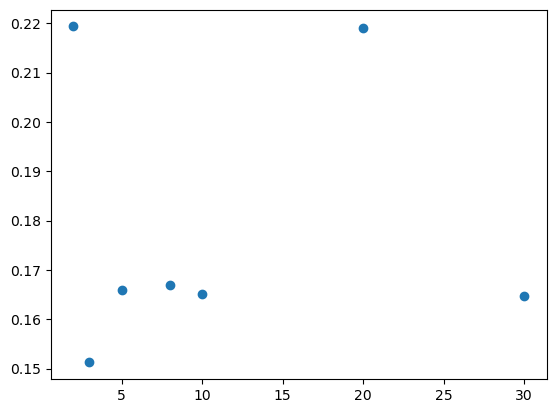

In [213]:
plt.scatter(k_list, precision_list.iloc[0, 1:].values)